In [9]:
import pandas as pd
from pandas_datareader import wb
import io
import warnings # Uyarıları yönetmek için gerekli kütüphane

# Gereksiz "FutureWarning" uyarılarını gizliyoruz
warnings.simplefilter(action='ignore', category=FutureWarning)

# =============================================================================
# ADIM 1: TEMEL VERİ SETİNİN OLUŞTURULMASI (Ülkeler, Kıtalar ve Siyasi Yönelim)
# =============================================================================
csv_skeleton = """Country,Continent,Political_Orientation,incomeLevel
Afghanistan,Asia,Right,LIC
Albania,Europe,Left,UMC
Algeria,Africa,Center,UMC
Argentina,South America,Left,UMC
Australia,Oceania,Left,HIC
Austria,Europe,Right,HIC
Azerbaijan,Asia,Right,UMC
Belgium,Europe,Center,HIC
Bolivia,South America,Left,LMC
Bosnia and Herzegovina,Europe,Right,UMC
Brazil,South America,Right,UMC
Bulgaria,Europe,Center,HIC
Canada,North America,Left,HIC
Chile,South America,Left,HIC
China,Asia,Left,UMC
Colombia,South America,Left,UMC
Costa Rica,North America,Right,HIC
Croatia,Europe,Right,HIC
Cyprus,Europe,Right,HIC
Czechia,Europe,Right,HIC
Denmark,Europe,Left,HIC
Ecuador,South America,Right,UMC
Egypt,Africa,Right,LMC
Estonia,Europe,Right,HIC
Finland,Europe,Left,HIC
France,Europe,Center,HIC
Georgia,Asia,Center,UMC
Germany,Europe,Left,HIC
Ghana,Africa,Right,LMC
Greece,Europe,Right,HIC
Hungary,Europe,Right,HIC
Iceland,Europe,Left,HIC
India,Asia,Right,LMC
Indonesia,Asia,Center,UMC
Iran,Asia,Right,UMC
Iraq,Asia,Right,UMC
Ireland,Europe,Right,HIC
Israel,Asia,Right,HIC
Italy,Europe,Right,HIC
Japan,Asia,Right,HIC
Kazakhstan,Asia,Center,UMC
Kenya,Africa,Right,LMC
"Korea, Rep.",Asia,Right,HIC
Latvia,Europe,Right,HIC
Lithuania,Europe,Right,HIC
Malaysia,Asia,Center,UMC
Mexico,North America,Left,UMC
Moldova,Europe,Right,UMC
Mongolia,Asia,Left,UMC
Morocco,Africa,Right,LMC
Netherlands,Europe,Right,HIC
New Zealand,Oceania,Left,HIC
Nigeria,Africa,Left,LMC
North Macedonia,Europe,Left,UMC
Norway,Europe,Left,HIC
Pakistan,Asia,Right,LMC
Peru,South America,Left,UMC
Philippines,Asia,Right,LMC
Poland,Europe,Right,HIC
Portugal,Europe,Left,HIC
Qatar,Asia,Right,HIC
Romania,Europe,Right,HIC
Russian Federation,Europe,Right,HIC
Saudi Arabia,Asia,Right,HIC
Serbia,Europe,Right,UMC
Singapore,Asia,Right,HIC
Slovak Republic,Europe,Right,HIC
Slovenia,Europe,Center,HIC
South Africa,Africa,Left,UMC
Spain,Europe,Left,HIC
Sri Lanka,Asia,Right,LMC
Sweden,Europe,Right,HIC
Switzerland,Europe,Right,HIC
Thailand,Asia,Right,UMC
Tunisia,Africa,Center,LMC
Turkiye,Europe,Right,UMC
Ukraine,Europe,Center,UMC
United Arab Emirates,Asia,Right,HIC
United Kingdom,Europe,Right,HIC
United States,North America,Left,HIC
Uruguay,South America,Right,HIC
Uzbekistan,Asia,Center,LMC
"Venezuela, RB",South America,Left,INX
Vietnam,Asia,Left,LMC
"""

# Metni DataFrame'e çeviriyoruz
df_base = pd.read_csv(io.StringIO(csv_skeleton))

# =============================================================================
# ADIM 2: DÜNYA BANKASI API'SINDAN VERİ ÇEKME
# =============================================================================
print("Veriler Dünya Bankası'ndan çekiliyor, lütfen bekleyin...")

# WDI (World Development Indicators) Kodları
indicators = {
    'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
    'SE.SEC.ENRR.FE': 'School enrollment secondary female (% gross)',
    'SE.SEC.ENRR.MA': 'School enrollment secondary male (% gross)',
    'SI.POV.GINI': 'Gini Index',
    'SP.DYN.LE00.IN': 'Life Expectancy',
    'IT.NET.USER.ZS': 'Internet Usage %',
    'SL.TLF.CACT.FE.ZS': 'Female Labor Force %'
}

# API İsteği (Start yılını 2020 yaparak veri bulma şansını artırdım, en güncelini alacağız zaten)
# DÜZELTME: warnings kütüphanesi ile uyarı bastırıldı.
try:
    wb_data = wb.download(indicator=list(indicators.keys()), country='all', start=2020, end=2023)
    wb_data = wb_data.reset_index()
except Exception as e:
    print(f"Veri çekme hatası: {e}")
    # Hata durumunda boş dataframe oluştur ki kod çökmesin
    wb_data = pd.DataFrame(columns=['country', 'date'] + list(indicators.keys()))

# Sütun İsimlerini Düzeltme
wb_data = wb_data.rename(columns=indicators)

# Gruplama ve En Güncel Veriyi Alma (Yıla göre sıralayıp en sonuncuyu alıyoruz)
target_cols = list(indicators.values())

# 'year' veya 'date' sütunu hangisiyse ona göre sıralama yapalım
if 'date' in wb_data.columns:
    wb_data = wb_data.sort_values('date', ascending=False)
elif 'year' in wb_data.columns:
    wb_data = wb_data.sort_values('year', ascending=False)

# Her ülke için ilk (en güncel) dolu kaydı al
wb_data_grouped = wb_data.groupby('country')[target_cols].first().reset_index()
wb_data_grouped = wb_data_grouped.rename(columns={'country': 'Country'})

# =============================================================================
# ADIM 3: VERİ TEMİZLEME VE BİRLEŞTİRME
# =============================================================================

corrections = {
    'Turkey': 'Turkiye',
    'Slovak Republic': 'Slovak Republic',
    'Egypt, Arab Rep.': 'Egypt',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'Korea, Rep.',
    'Russia': 'Russian Federation',
    'Venezuela, RB': 'Venezuela, RB',
    'Viet Nam': 'Vietnam',
    'Yemen, Rep.': 'Yemen'
}
wb_data_grouped['Country'] = wb_data_grouped['Country'].replace(corrections)

# Birleştirme
df_final = pd.merge(df_base, wb_data_grouped, on='Country', how='left')

# =============================================================================
# ADIM 4: KAYDETME
# =============================================================================

cols = [
    'Country', 'incomeLevel', 
    'GDP per capita (current US$)', 
    'School enrollment secondary female (% gross)',
    'School enrollment secondary male (% gross)',
    'Continent', 
    'Gini Index', 
    'Life Expectancy', 
    'Internet Usage %', 
    'Female Labor Force %', 
    'Political_Orientation'
]

# Mevcut sütunları seçip kaydet
existing_cols = [c for c in cols if c in df_final.columns]
df_final = df_final[existing_cols]

df_final.to_csv('DSA_Project_Data.csv', index=False)
    
print("\n--- İŞLEM BAŞARILI ---")
print("Dosya 'DSA_Project_Data.csv' adıyla kaydedildi.")
print(df_final.head())

Veriler Dünya Bankası'ndan çekiliyor, lütfen bekleyin...

--- İŞLEM BAŞARILI ---
Dosya 'DSA_Project_Data.csv' adıyla kaydedildi.
       Country incomeLevel  GDP per capita (current US$)  \
0  Afghanistan         LIC                    413.757895   
1      Albania         UMC                   9730.869219   
2      Algeria         UMC                   5370.477235   
3    Argentina         UMC                  14261.846567   
4    Australia         HIC                  65058.377315   

   School enrollment secondary female (% gross)  \
0                                           NaN   
1                                     92.668293   
2                                    103.220718   
3                                    107.980731   
4                                    131.097336   

   School enrollment secondary male (% gross)      Continent  Gini Index  \
0                                         NaN           Asia         NaN   
1                                   99.499010      

In [10]:
import pandas as pd

# 1. HAM VERİYİ YÜKLE
try:
    df = pd.read_csv('DSA_Project_Data.csv')
    print(f"Orijinal Veri Sayısı: {len(df)} satır")
except FileNotFoundError:
    print("Hata: 'DSA_Project_Data.csv' bulunamadı.")
    exit()

# 2. TEMİZLİK İŞLEMİ (Sadece Eksik Verileri Atıyoruz)
# Verisi eksik olan ülkeleri siliyoruz çünkü model bunlarla çalışamaz.
df_clean = df.dropna().reset_index(drop=True)

# 3. KONTROL
print(f"Temizlenmiş Veri Sayısı: {len(df_clean)} satır")
print(f"Silinen Ülke Sayısı: {len(df) - len(df_clean)}")

# Hangi ülkeler kaldı bir görelim
print("\nVeri Setindeki İlk 5 Ülke:")
print(df_clean[['Country', 'Continent', 'Political_Orientation']].head())

# 4. KAYDETME
# Bu dosya EDA yapmak (grafik çizmek) için kullanacağın ana dosyadır.
df_clean.to_csv('DSA_Project_Data_clean.csv', index=False)

print("\n--- İŞLEM TAMAM ---")
print("Dosya 'DSA_Project_Data_clean.csv' olarak kaydedildi.")

Orijinal Veri Sayısı: 84 satır
Temizlenmiş Veri Sayısı: 63 satır
Silinen Ülke Sayısı: 21

Veri Setindeki İlk 5 Ülke:
     Country      Continent Political_Orientation
0    Albania         Europe                  Left
1  Argentina  South America                  Left
2  Australia        Oceania                  Left
3    Austria         Europe                 Right
4    Belgium         Europe                Center

--- İŞLEM TAMAM ---
Dosya 'DSA_Project_Data_clean.csv' olarak kaydedildi.


--- İSTATİSTİKSEL ÖZET ---
                                              count          mean  \
GDP per capita (current US$)                   63.0  28341.215726   
School enrollment secondary female (% gross)   63.0    104.236700   
School enrollment secondary male (% gross)     63.0    102.333238   
Gini Index                                     63.0     34.193651   
Life Expectancy                                63.0     77.725583   
Internet Usage %                               63.0     85.731384   
Female Labor Force %                           63.0     53.905873   

                                                       std          min  \
GDP per capita (current US$)                  25555.984970  1942.588028   
School enrollment secondary female (% gross)     18.135542    47.406151   
School enrollment secondary male (% gross)       15.604805    46.398590   
Gini Index                                        6.512986    23.800000   
Life Expectancy                              

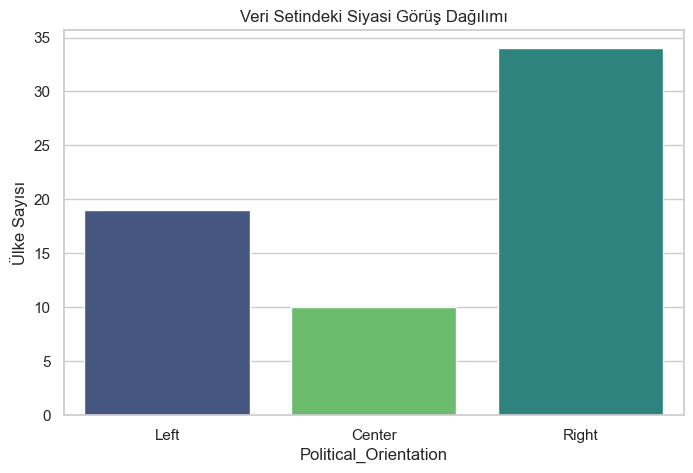


Yorum: Bu grafik, veri setinin dengeli olup olmadığını gösterir. Eğer bir sütun çok kısaysa model o sınıfı öğrenmekte zorlanabilir.


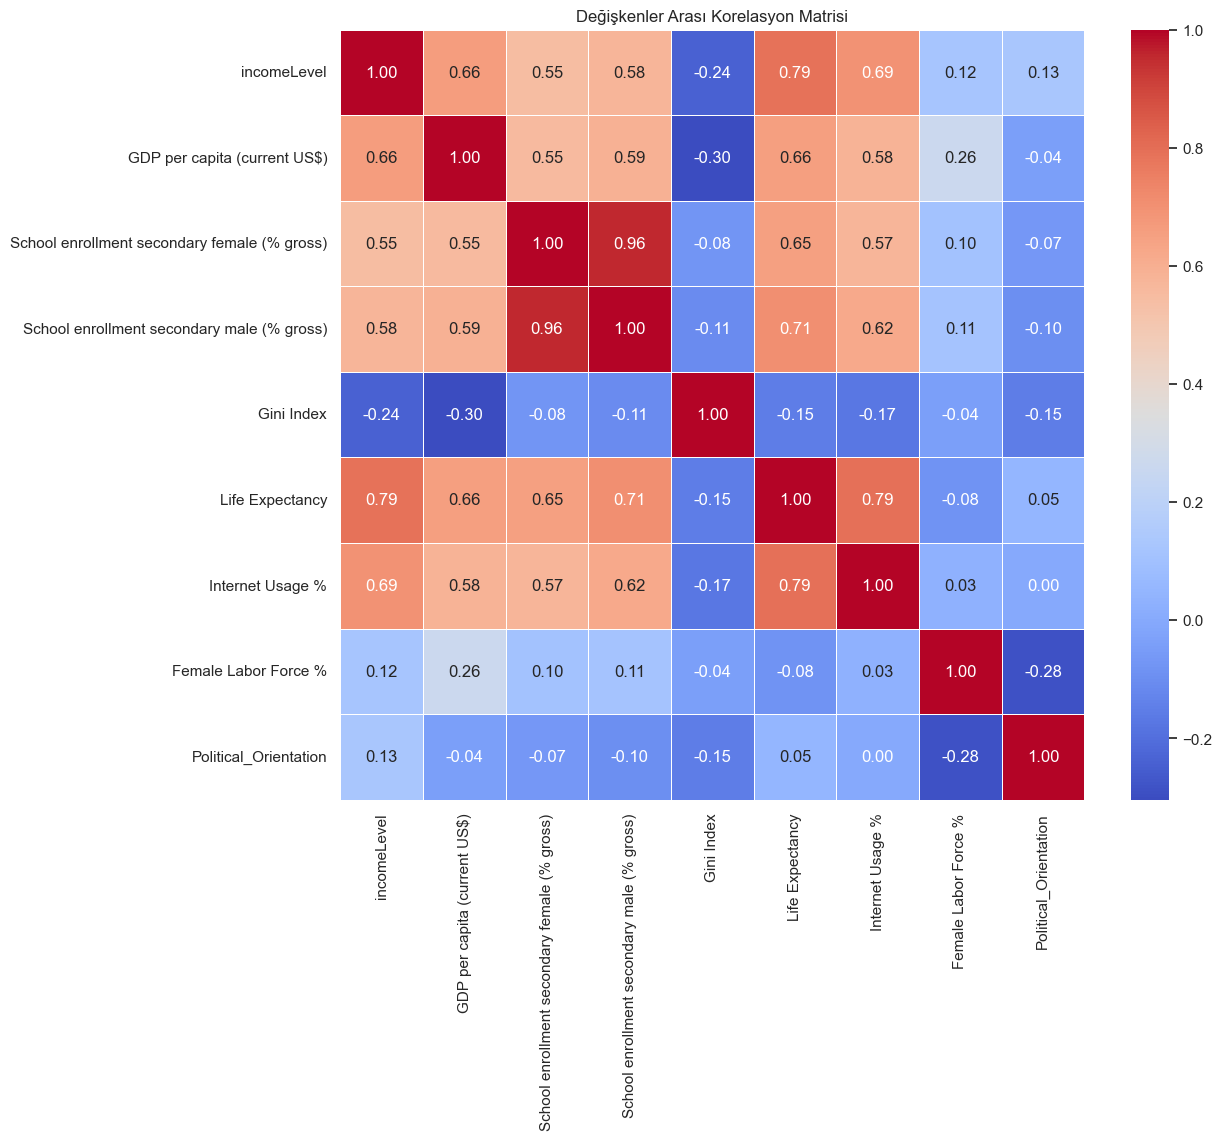


Yorum: Kırmızı kareler pozitif ilişkiyi (biri artarsa diğeri de artar), mavi kareler negatif ilişkiyi gösterir.


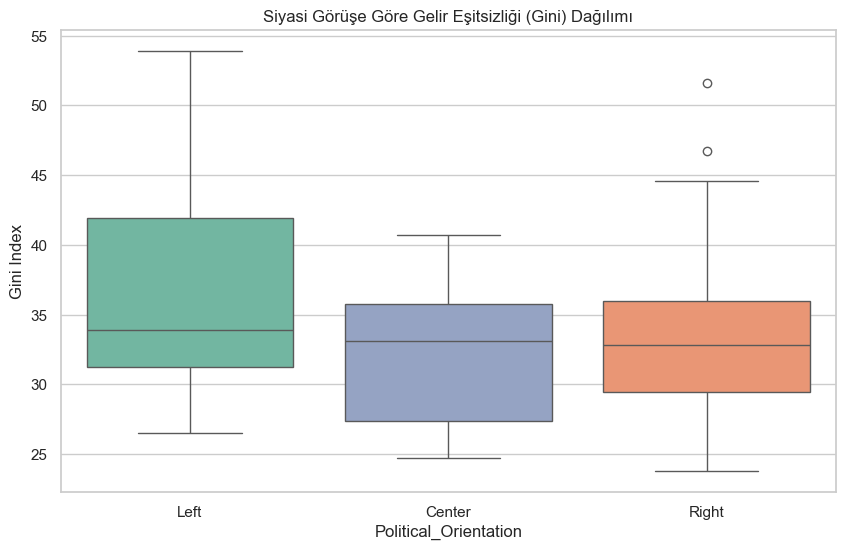

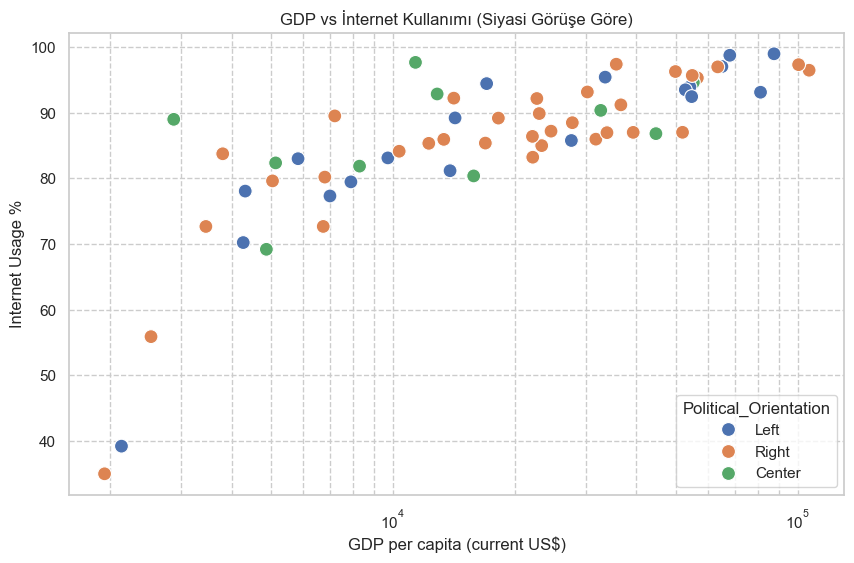


--- EDA TAMAMLANDI ---


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Görsel ayarları (Daha şık grafikler için)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. TEMİZ VERİYİ YÜKLE
try:
    df = pd.read_csv('DSA_Project_Data_clean.csv')
except FileNotFoundError:
    print("Dosya bulunamadı! Lütfen önce temizleme kodunu çalıştır.")
    exit()

# --- ADIM 1: VERİYE GENEL BAKIŞ (Sayısal Özet) ---
print("--- İSTATİSTİKSEL ÖZET ---")
# describe() komutu ortalama, min, max değerlerini döker.
print(df.describe().T) 

# --- ADIM 2: HEDEF DEĞİŞKEN DAĞILIMI (Siyasi Görüş) ---
plt.figure(figsize=(8, 5))

# DÜZELTME 1: hue eklendi ve legend kapatıldı
sns.countplot(
    x='Political_Orientation', 
    data=df, 
    hue='Political_Orientation', # Renklendirme kriteri
    legend=False,                # Tekrar eden lejantı kapat
    palette='viridis', 
    order=['Left', 'Center', 'Right']
)

plt.title("Veri Setindeki Siyasi Görüş Dağılımı")
plt.ylabel("Ülke Sayısı")
plt.show()
print("\nYorum: Bu grafik, veri setinin dengeli olup olmadığını gösterir. Eğer bir sütun çok kısaysa model o sınıfı öğrenmekte zorlanabilir.")

# --- ADIM 3: KORELASYON HARİTASI (HEATMAP) ---
# Not: Heatmap sayı istediği için geçici bir kopya üzerinde dönüşüm yapıyoruz.
df_corr = df.copy()
politics_map = {'Left': 0, 'Center': 1, 'Right': 2}
income_map = {'LIC': 1, 'LMC': 2, 'UMC': 3, 'HIC': 4, 'INX': 0}

# Haritalamada hata olmaması için varsa eksikleri dolduralım veya dikkatli olalım
df_corr['Political_Orientation'] = df_corr['Political_Orientation'].map(politics_map)
df_corr['incomeLevel'] = df_corr['incomeLevel'].map(income_map)

# Sadece sayısal sütunları seçip korelasyona bakıyoruz
numeric_cols = df_corr.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Değişkenler Arası Korelasyon Matrisi")
plt.show()
print("\nYorum: Kırmızı kareler pozitif ilişkiyi (biri artarsa diğeri de artar), mavi kareler negatif ilişkiyi gösterir.")

# --- ADIM 4: DETAYLI İLİŞKİ ANALİZLERİ (Boxplot & Scatter) ---

# Analiz A: Siyasi Görüş ve Gelir Adaletsizliği (Gini Index)
# "Sağcı ülkelerde mi yoksa Solcu ülkelerde mi gelir eşitsizliği daha fazla?"
plt.figure(figsize=(10, 6))

# DÜZELTME 2: hue eklendi ve legend kapatıldı
sns.boxplot(
    x='Political_Orientation', 
    y='Gini Index', 
    data=df, 
    hue='Political_Orientation', # Renklendirme kriteri
    legend=False,                # Tekrar eden lejantı kapat
    palette='Set2', 
    order=['Left', 'Center', 'Right']
)

plt.title("Siyasi Görüşe Göre Gelir Eşitsizliği (Gini) Dağılımı")
plt.show()

# Analiz B: Zenginlik ve İnternet Kullanımı İlişkisi (Siyasi Renklendirme ile)
plt.figure(figsize=(10, 6))
# Scatterplot'ta zaten hue var, o yüzden burada hata vermez.
sns.scatterplot(x='GDP per capita (current US$)', y='Internet Usage %', hue='Political_Orientation', data=df, palette='deep', s=100)
plt.title("GDP vs İnternet Kullanımı (Siyasi Görüşe Göre)")
plt.xscale('log') # GDP çok değişken olduğu için logaritmik ölçek kullanıyoruz
plt.grid(True, which="both", ls="--")
plt.show()

print("\n--- EDA TAMAMLANDI ---")

In [12]:
import pandas as pd
from scipy import stats

# Veri
df = pd.read_csv('DSA_Project_Data_clean.csv')


print("\n--- EK HİPOTEZ TESTLERİ (4, 5, 6) ---\n")

# =============================================================================
# TEST 4: "COĞRAFYA KADER MİDİR?" (ANOVA - Kıta ve GDP)
# H0: Bütün kıtaların gelir ortalamaları EŞİTTİR.
# H1: En az bir kıta diğerlerinden anlamlı derecede farklıdır.
# =============================================================================
print("TEST 4: Kıtalar Arası Gelir Farklılığı (ANOVA)")

# Her kıtanın GDP verilerini bir listede topluyoruz
continents = df['Continent'].unique()
gdp_groups = [df[df['Continent'] == c]['GDP per capita (current US$)'] for c in continents]

# Grupları teste sokuyoruz 
f_stat, p_value = stats.f_oneway(*gdp_groups)

print(f"F-İstatistiği: {f_stat:.4f}")
print(f"P-Değeri: {p_value:.4e}")

if p_value < 0.05:
    print("SONUÇ: H0 Reddedildi. Kıtalar arasında UÇURUM (anlamlı gelir farkı) var.")
else:
    print("SONUÇ: H0 Reddedilemedi. Kıtaların gelirleri benzer.")
print("-" * 50)


# =============================================================================
# TEST 5: "PARA SAĞLIK GETİRİR Mİ?" (Pearson Korelasyonu - GDP vs Yaşam Süresi)
# H0: Zenginlik ile uzun yaşam arasında ilişki YOKTUR.
# H1: İlişki VARDIR.
# =============================================================================
print("\nTEST 5: GDP ile Yaşam Beklentisi İlişkisi (Pearson)")

# Korelasyon hesabı
corr_coef, p_value_corr = stats.pearsonr(df['GDP per capita (current US$)'], df['Life Expectancy'])

print(f"Korelasyon Katsayısı (r): {corr_coef:.4f}")
print(f"P-Değeri: {p_value_corr:.4e}")

if p_value_corr < 0.05:
    if corr_coef > 0:
        print("SONUÇ: H0 Reddedildi. Zenginlik arttıkça yaşam süresi ANLAMLI şekilde artıyor.")
    else:
        print("SONUÇ: H0 Reddedildi. Ancak ters bir ilişki var (Beklenmedik durum).")
else:
    print("SONUÇ: H0 Reddedilemedi. Para ile sağlık arasında bağ kurulamadı.")
print("-" * 50)


# =============================================================================
# TEST 6: "SİYASET EĞİTİMİ ETKİLER Mİ?" (ANOVA - Politics vs Female Education)
# H0: Sağ, Sol ve Merkez ülkelerde kadın okullaşma oranı EŞİTTİR.
# H1: Farklılık gösterir.
# =============================================================================
print("\nTEST 6: Siyasi Görüşe Göre Kadın Eğitimi Farkı (ANOVA)")

edu_right = df[df['Political_Orientation'] == 'Right']['School enrollment secondary female (% gross)']
edu_left = df[df['Political_Orientation'] == 'Left']['School enrollment secondary female (% gross)']
edu_center = df[df['Political_Orientation'] == 'Center']['School enrollment secondary female (% gross)']

f_stat, p_value = stats.f_oneway(edu_right, edu_left, edu_center)

print(f"F-İstatistiği: {f_stat:.4f}")
print(f"P-Değeri: {p_value:.4f}")

if p_value < 0.05:
    print("SONUÇ: H0 Reddedildi. Bazı siyasi görüşlerde kadın eğitimi istatistiksel olarak daha farklı.")
else:
    print("SONUÇ: H0 Reddedilemedi. Siyasetin kadın eğitimi üzerinde doğrudan bir etkisi görülmedi.")
print("-" * 50)


--- EK HİPOTEZ TESTLERİ (4, 5, 6) ---

TEST 4: Kıtalar Arası Gelir Farklılığı (ANOVA)
F-İstatistiği: 5.2120
P-Değeri: 5.2297e-04
SONUÇ: H0 Reddedildi. Kıtalar arasında UÇURUM (anlamlı gelir farkı) var.
--------------------------------------------------

TEST 5: GDP ile Yaşam Beklentisi İlişkisi (Pearson)
Korelasyon Katsayısı (r): 0.6570
P-Değeri: 4.9953e-09
SONUÇ: H0 Reddedildi. Zenginlik arttıkça yaşam süresi ANLAMLI şekilde artıyor.
--------------------------------------------------

TEST 6: Siyasi Görüşe Göre Kadın Eğitimi Farkı (ANOVA)
F-İstatistiği: 0.2846
P-Değeri: 0.7533
SONUÇ: H0 Reddedilemedi. Siyasetin kadın eğitimi üzerinde doğrudan bir etkisi görülmedi.
--------------------------------------------------


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

# 1. VERİYİ YÜKLEME
# Temizlenmiş verisetini okuyoruz
df = pd.read_csv('DSA_Project_Data_cleaned.csv')

# 2. ÖZNİTELİK MÜHENDİSLİĞİ (Feature Engineering)
# Proje hipotezin olan "Cinsiyet Eğitim Farkı" değişkenini oluşturuyoruz.
# Pozitif değer: Erkekler avantajlı, Negatif değer: Kadınlar avantajlı.
if 'School enrollment secondary male (% gross)' in df.columns:
    df['Gender_Gap'] = df['School enrollment secondary male (% gross)'] - df['School enrollment secondary female (% gross)']

# 3. VERİ ÖN İŞLEME (Preprocessing)
# Hedef değişkenimiz (y): Siyasi Yönelim. Bunu sayıya çeviriyoruz (Label Encoding).
le = LabelEncoder()
df['Political_Encoded'] = le.fit_transform(df['Political_Orientation'])

# Girdi değişkenleri (X):
# Gelir seviyesi (incomeLevel) ve gereksiz sütunları çıkarıyoruz.
drop_cols = ['Country', 'Political_Orientation', 'Political_Encoded', 'incomeLevel']
X = df.drop(columns=drop_cols)
y = df['Political_Encoded']

# Kategorik Veriler İçin: One-Hot Encoding
X = pd.get_dummies(X, columns=['Continent'], drop_first=True)

# 4. EĞİTİM VE TEST SETİNE AYIRMA
# Verinin %80'i ile modeli eğiteceğiz, %20'si ile test edeceğiz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Sınıflandırma Standardı: UNESCO GPI (0.97 - 1.03)
Sınıf Dağılımı:
Target_Class
1    111
0     48
Name: count, dtype: int64

--- Grid Search Başlıyor (En İyi Parametreler Aranıyor) ---
Random Forest En İyi Parametreler: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Random Forest En İyi Skor (CV): 0.7720
KNN En İyi Parametreler: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
KNN En İyi Skor (CV): 0.7800


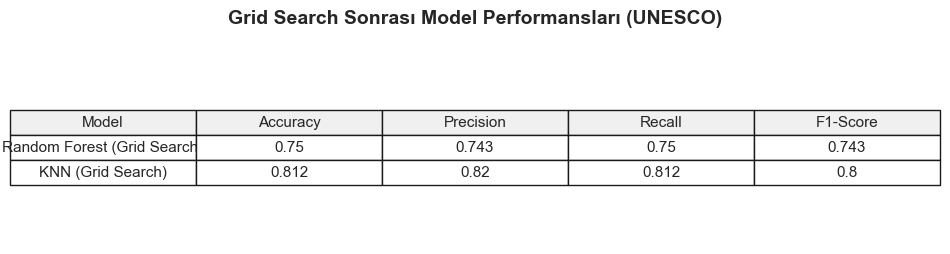

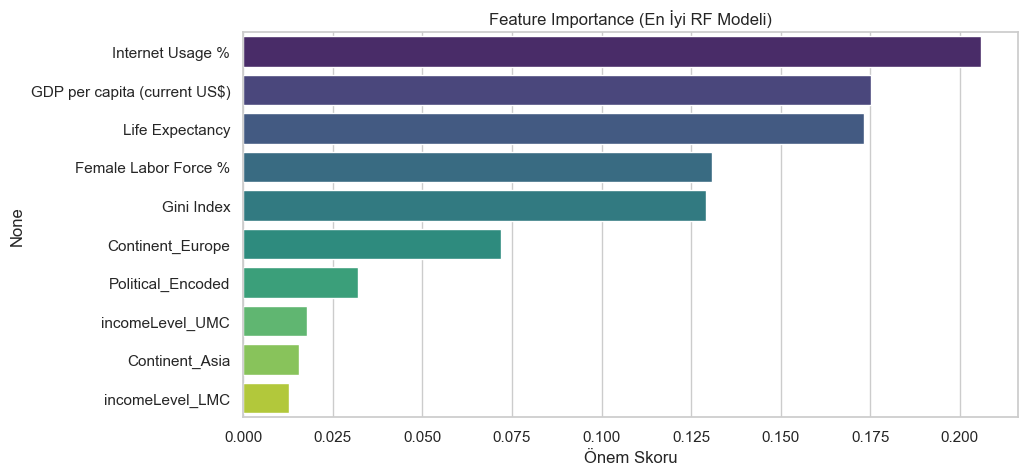

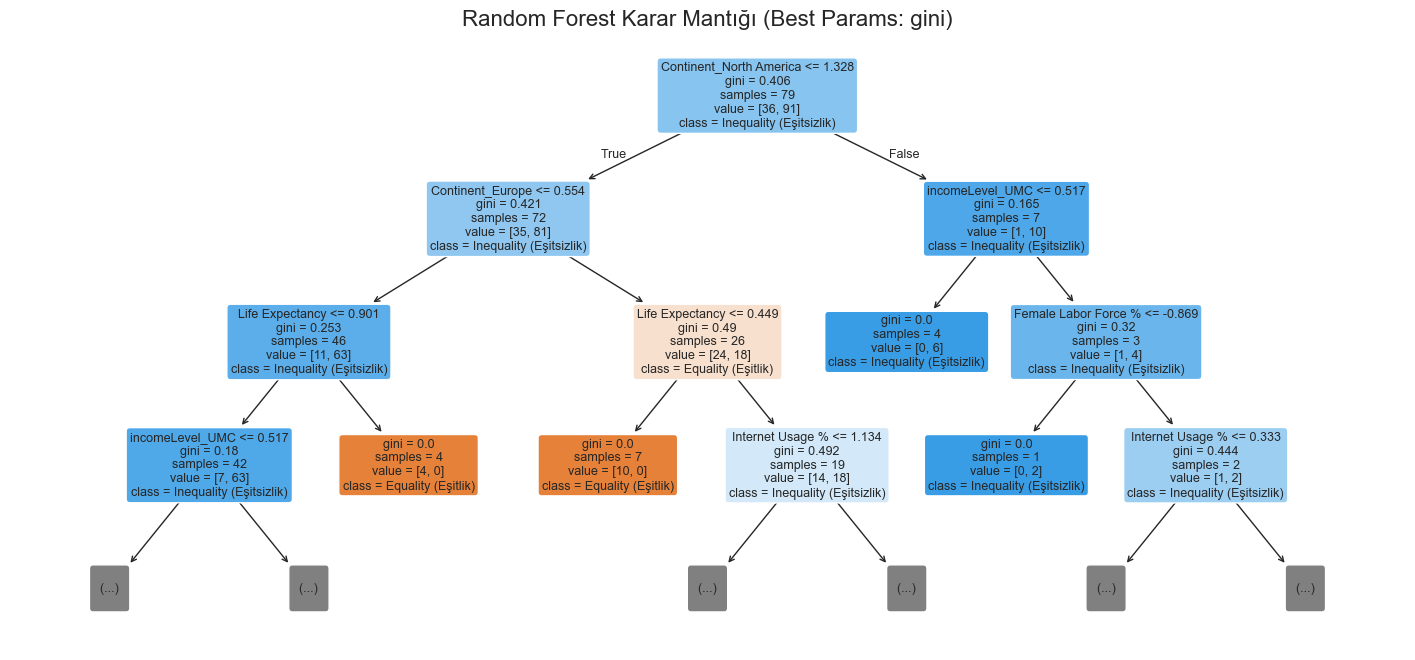

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

# 1. VERİYİ YÜKLEME VE HAZIRLAMA
df = pd.read_csv('DSA_Project_Data_cleaned.csv')

# UNESCO GPI HESAPLAMA
male_col = 'School enrollment secondary male (% gross)'
female_col = 'School enrollment secondary female (% gross)'

if male_col in df.columns and female_col in df.columns:
    df['GPI'] = df[female_col] / (df[male_col] + 0.0001)
    
    # HEDEF: UNESCO Standardı (0.97 - 1.03)
    df['Target_Class'] = (~df['GPI'].between(0.97, 1.03)).astype(int)
    y = df['Target_Class']
    
    class_names = ['Equality (Eşitlik)', 'Inequality (Eşitsizlik)']
    
    print("Sınıflandırma Standardı: UNESCO GPI (0.97 - 1.03)")
    print(f"Sınıf Dağılımı:\n{df['Target_Class'].value_counts()}")
else:
    raise ValueError("Gerekli eğitim sütunları bulunamadı!")

# GİRDİLERİ HAZIRLAMA
le_pol = LabelEncoder()
df['Political_Encoded'] = le_pol.fit_transform(df['Political_Orientation'].fillna('Unknown'))

cols_to_drop = ['Country', 'Political_Orientation', 'Target_Class', 'GPI', 
                male_col, female_col]
if 'Gender_Gap' in df.columns: cols_to_drop.append('Gender_Gap')
    
existing_drops = [c for c in cols_to_drop if c in df.columns]
X = df.drop(columns=existing_drops)

# PREPROCESSING
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# SPLIT 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- 2. GRID SEARCH İLE MODEL OPTİMİZASYONU ---

print("\n--- Grid Search Başlıyor (En İyi Parametreler Aranıyor) ---")

# A) Random Forest İçin Grid
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],      
    'min_samples_leaf': [1, 2, 4],   
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_final = rf_grid.best_estimator_

print(f"Random Forest En İyi Parametreler: {rf_grid.best_params_}")
print(f"Random Forest En İyi Skor (CV): {rf_grid.best_score_:.4f}")

# B) KNN İçin Grid
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_final = knn_grid.best_estimator_

print(f"KNN En İyi Parametreler: {knn_grid.best_params_}")
print(f"KNN En İyi Skor (CV): {knn_grid.best_score_:.4f}")

# TAHMİNLER
y_pred_rf = rf_final.predict(X_test)
y_pred_knn = knn_final.predict(X_test)

# 3. GÖRSELLEŞTİRME

# --- A) PERFORMANS TABLOSU ---
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True, zero_division=0)

metrics_data = {
    'Model': ['Random Forest (Grid Search)', 'KNN (Grid Search)'],
    'Accuracy': [report_rf['accuracy'], report_knn['accuracy']],
    'Precision': [report_rf['weighted avg']['precision'], report_knn['weighted avg']['precision']],
    'Recall': [report_rf['weighted avg']['recall'], report_knn['weighted avg']['recall']],
    'F1-Score': [report_rf['weighted avg']['f1-score'], report_knn['weighted avg']['f1-score']]
}
df_metrics = pd.DataFrame(metrics_data).round(3)

fig, ax = plt.subplots(figsize=(10, 2.5))
ax.axis('tight')
ax.axis('off')
ax.set_title("Grid Search Sonrası Model Performansları (UNESCO)", fontsize=14, fontweight='bold', pad=20)
table = ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns, loc='center', cellLoc='center', colColours=['#f0f0f0']*5)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)
plt.show()

# --- B) FEATURE IMPORTANCE (RF) - DÜZELTİLDİ ---
feature_importances = pd.Series(rf_final.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))

# DÜZELTME: hue parametresi eklendi ve legend kapatıldı
sns.barplot(
    x=feature_importances.head(10), 
    y=feature_importances.head(10).index, 
    hue=feature_importances.head(10).index, # Renklendirmeyi indekse göre yap dedik
    legend=False, # Gereksiz lejantı kapattık
    palette='viridis'
)

plt.title('Feature Importance (En İyi RF Modeli)')
plt.xlabel('Önem Skoru')
plt.show()

# --- C) KARAR AĞACI ---
plt.figure(figsize=(18, 8))
plot_tree(rf_final.estimators_[0], 
          feature_names=X.columns,
          class_names=class_names,
          filled=True, 
          rounded=True,
          fontsize=9,
          max_depth=3) 
plt.title(f"Random Forest Karar Mantığı (Best Params: {rf_grid.best_params_['criterion']})", fontsize=16)
plt.show()

UNESCO Durumu Etiketlendi.
Inequality_Status
Esitsizlik Var (Inequality)    111
Esitsizlik Yok (Equality)       48
Name: count, dtype: int64

--- Optimum Küme Sayısı (Elbow Yöntemi) Aranıyor ---


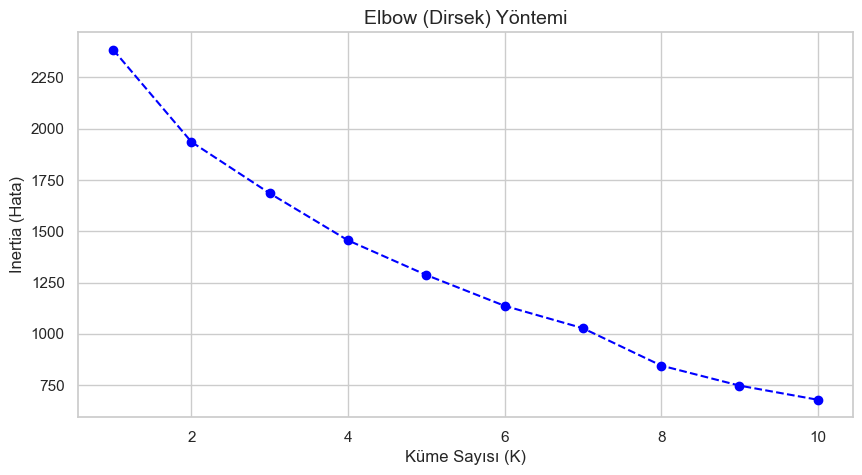


>>> Seçilen Küme Sayısı (K): 3

--- ÇARPRAZ TABLO: Hangi Kümede Kaç Tane 'Eşitsizlik Var/Yok'? ---
Inequality_Status  Esitsizlik Var (Inequality)  Esitsizlik Yok (Equality)
Cluster                                                                  
0                                           19                         30
1                                           52                          8
2                                           40                         10

--- Kümelerin Siyasi Dağılımı ---
Political_Orientation  Center  Left  Right
Cluster                                   
0                           4    12     33
1                           9    18     33
2                          11    21     18


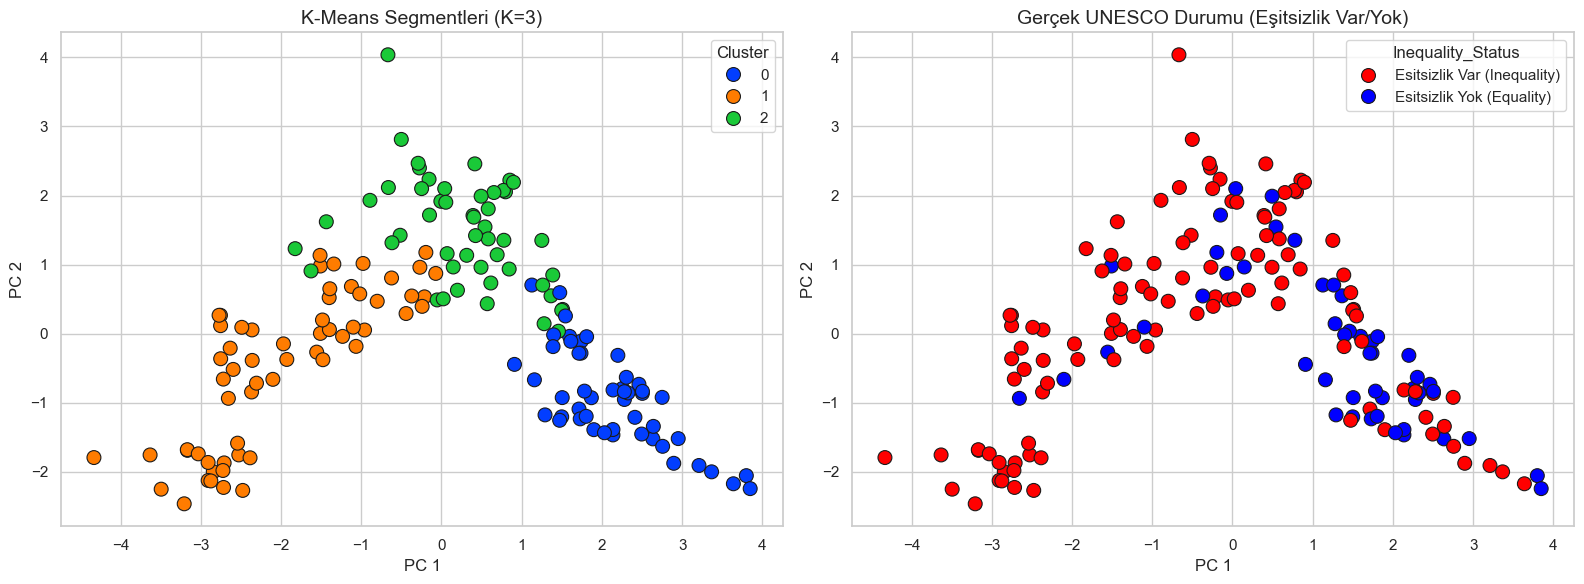

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

# 1. VERİYİ YÜKLEME
df = pd.read_csv('DSA_Project_Data_cleaned.csv')

# --- ADIM 1: UNESCO EŞİTSİZLİK ETİKETİNİ OLUŞTURMA ---
male_col = 'School enrollment secondary male (% gross)'
female_col = 'School enrollment secondary female (% gross)'

if male_col in df.columns and female_col in df.columns:
    # 0'a bölünme hatasını önlemek için minik sayı ekle
    df['GPI'] = df[female_col] / (df[male_col] + 0.0001)
    
    # KURAL: 0.97 ile 1.03 arası "Eşitsizlik Yok" (Eşitlik), Diğerleri "Eşitsizlik Var"
    df['Inequality_Status'] = np.where(df['GPI'].between(0.97, 1.03), 
                                       'Esitsizlik Yok (Equality)', 
                                       'Esitsizlik Var (Inequality)')
    
    print("UNESCO Durumu Etiketlendi.")
    print(df['Inequality_Status'].value_counts())
else:
    print("Gerekli sütunlar eksik, etiketleme yapılamadı.")

# 2. GİRDİLERİ HAZIRLAMA
le = LabelEncoder()
df['Political_Encoded'] = le.fit_transform(df['Political_Orientation'].fillna('Unknown'))

# Etiketleri (Sonuçları) Eğitimden Çıkarıyoruz
cols_to_drop = ['Country', 'Political_Orientation', 'Inequality_Status', 'GPI',
                'School enrollment secondary male (% gross)', 'School enrollment secondary female (% gross)']

if 'Gender_Gap' in df.columns: cols_to_drop.append('Gender_Gap')
elif male_col in df.columns:
    df['Gender_Gap'] = df[male_col] - df[female_col]
    cols_to_drop.append('Gender_Gap')

existing_drops = [c for c in cols_to_drop if c in df.columns]

X_cluster = df.drop(columns=existing_drops)
X_cluster['Political_Encoded'] = df['Political_Encoded']

# Kategorik verileri sayıya çevir ve eksikleri doldur
X_cluster = pd.get_dummies(X_cluster, drop_first=True)
X_cluster = X_cluster.fillna(X_cluster.mean())

# 3. ÖLÇEKLENDİRME 
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_cluster)

# --- ADIM 2: ELBOW (DİRSEK) YÖNTEMİ ---
print("\n--- Optimum Küme Sayısı (Elbow Yöntemi) Aranıyor ---")
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled_full)
    inertia.append(kmeans_temp.inertia_)

# Dirsek Grafiğini Çiz
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='blue')
plt.title('Elbow (Dirsek) Yöntemi', fontsize=14)
plt.xlabel('Küme Sayısı (K)')
plt.ylabel('Inertia (Hata)')
plt.grid(True)
plt.show()

# --- ADIM 3: FİNAL MODELİ KURMA ---
# NOT: Dirsek grafiğine bakarak burayı değiştirebilirsin.
# Biz hikayesi en düzgün olan 3 ile devam ediyoruz.
optimal_k = 3 
print(f"\n>>> Seçilen Küme Sayısı (K): {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled_full)
df['Cluster'] = clusters

# --- ADIM 4: ANALİZ (KÜMELER vs UNESCO EŞİTSİZLİK) ---
print("\n--- ÇARPRAZ TABLO: Hangi Kümede Kaç Tane 'Eşitsizlik Var/Yok'? ---")
print(pd.crosstab(df['Cluster'], df['Inequality_Status']))

print("\n--- Kümelerin Siyasi Dağılımı ---")
print(pd.crosstab(df['Cluster'], df['Political_Orientation']))

# --- ADIM 5: GÖRSELLEŞTİRME ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_full)

plt.figure(figsize=(16, 6))

# Grafik 1: K-Means Kümeleri
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='bright', s=100, edgecolor='k')
plt.title(f'K-Means Segmentleri (K={optimal_k})', fontsize=14)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# Grafik 2: Gerçek UNESCO Durumu
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Inequality_Status'], 
                palette={'Esitsizlik Yok (Equality)': 'blue', 'Esitsizlik Var (Inequality)': 'red'}, 
                s=100, edgecolor='k')
plt.title('Gerçek UNESCO Durumu (Eşitsizlik Var/Yok)', fontsize=14)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.tight_layout()
plt.show()